In [1]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.device_count())

2.2.2+cu118
True
1


In [2]:
import torch
import torch.nn as nn
from torch import Tensor

In [3]:
class BitRMSNorm(nn.Module):
    def __init__(self, hidden_size, eps):
        """
        BitRMSNorm is equivalent to LlamaRMSNorm and T5LayerNorm
        refers: https://github.com/huggingface/transformers/blob/c5f0288bc7d76f65996586f79f69fba8867a0e67/src/transformers/models/llama/modeling_llama.py#L76C1-L90C59

        Args:
            hidden_size (_type_): _description_
            eps (_type_, optional): _description_. Defaults to 1e-6.
        """
        super().__init__()
        self.weight = nn.Parameter(torch.ones(hidden_size))
        self.variance_epsilon = eps

    def forward(self, hidden_states: Tensor) -> Tensor:
        input_dtype = hidden_states.dtype
        hidden_states = hidden_states.to(torch.float32)
        variance = hidden_states.pow(2).mean(-1, keepdim=True) # mean(x**2)
        hidden_states = hidden_states * torch.rsqrt(variance + self.variance_epsilon) # x / sqrt(mean(x**2) + epsilon)
        return self.weight * hidden_states.to(input_dtype)



class BitLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=False, rms_norm_eps=1e-6, bits=8, flg_before_linear=True):
        super(BitLinear, self).__init__(in_features, out_features, bias)
        self.layer_norm = BitRMSNorm(in_features, rms_norm_eps)
        self.bits = bits
        self.Qb = 2 ** (bits - 1)
        self.flg_before_linear = flg_before_linear
        self.epsilon = 1e-6
        

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass of the BitLinear layer.

        Args:
            x (Tensor): _description_

        Returns:
            Tensor: _description_
        """

        ###1. レイヤー正規化 (in: x, out: x_norm)
        #レイヤー正規化：https://i-main.net/emmanote-ai-normalization/#toc3
        #今回はRMSNormを使用
        x_norm = self.layer_norm(x)

        ###2. Absmax 量子化 (in: x_norm, out: x_q, gamma)
        x_q , gamma = self.absmax_quantize(x_norm)

        ###3. 1-bit Weight化 (in: - , out: w_q, beta)
        w_q, beta = self.quantize_weights()

        ###4. テンソル積 (in: x_q, gamma, out: x_matmul)
        x_matmul = torch.nn.functional.linear(x_q, w_q, self.bias)

        ###5. 逆量子化 (in: x_matmul, beta, gamma, out: x_out)
        output = x_matmul * (beta * gamma / self.Qb)

        return output

    def absmax_quantize(self, x):
        if self.flg_before_linear:
            # パターン①：　通常は[-Qb, Qb]にスケール: 式(4), (5)を適用
            gamma = torch.abs(x).max().clamp(min=self.epsilon)
            x_scaled = x * self.Qb / gamma
            x_q = torch.round(x_scaled).clamp(-self.Qb, self.Qb - 1)
        else:
            # パターン②：　Reluなどの非線形関数前の場合は[0, Qb]にスケール：　式(6)を適用
            # 論文中には記載はないですが、スケールが異なるためスケーリングの基準として使っているgammaもetaを反映した値にすべきだと考えます。
            eta = x.min()
            gamma = torch.abs(x - eta).max().clamp(min=self.epsilon)
            x_scaled = (x - eta) * self.Qb / gamma
            x_q = torch.round(x_scaled).clamp(0, self.Qb - 1)
        # STE
        x_q = (x_q - x_scaled).detach() + x_scaled
        return x_q, gamma
    
    def custom_sign(self, x):
        return (x > 0).to(torch.int8) * 2 - 1
    
    def quantize_weights(self):
        # 式(3): alphaの計算
        alpha = self.weight.mean()

        # 式(1),(2): 重みの中心化とバイナリ化
        weight_centered = self.weight - alpha
        weight_binarized = self.custom_sign(weight_centered)

        # 式(12): betaの計算
        beta = self.weight.abs().mean()

        # STE (weight_binarizedとスケールを合わせるためweight_centeredをweight_scaledにスケールしています。)
        weight_scaled = weight_centered / (weight_centered.abs().max() + self.epsilon)
        weight_binarized = (weight_binarized - weight_scaled).detach() + weight_scaled

        return weight_binarized, beta
    


In [4]:
#Mnistでの動作確認
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms

# データセットの読み込み：28x28の画像データ
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# モデルの定義
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        self.fc = nn.Linear(32, 10)
        self.fc_bit1 = BitLinear(28*28, 512, bits=8, flg_before_linear=False)
        self.fc_bit2 = BitLinear(512, 32, bits=8, flg_before_linear=False)


    def forward(self, x):
        x = self.fc_bit1(x)
        x = torch.relu(x)
        x = self.fc_bit2(x)
        x = torch.relu(x)
        x = self.fc(x)
        return x
    
model = MnistModel().cuda()

# 損失関数と最適化手法の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 学習
hist_avg_loss = []
hist_train_acc = []
hist_valid_acc = []
model.train()

for epoch in range(20):
    avg_loss = 0
    correct = 0
    total = 0
    for x, t in train_loader:
        x, t = x.cuda(), t.cuda()
        y = model(x)
        loss = criterion(y, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        _, pred = y.max(1)
        correct += (pred == t).sum().item()
        total += x.size(0)
    avg_loss /= len(train_loader)
    acc = correct / total
    hist_avg_loss.append(avg_loss)
    hist_train_acc.append(acc)

    correct = 0
    total = 0
    for x, t in test_loader:
        x, t = x.cuda(), t.cuda()
        y = model(x)
        _, pred = y.max(1)
        correct += (pred == t).sum().item()
        total += x.size(0)

    acc = correct / total
    hist_valid_acc.append(acc)

    print(f"epoch: {epoch}, avg_loss: {avg_loss}, train_acc: {hist_train_acc[-1]}, valid_acc: {hist_valid_acc[-1]}")


epoch: 0, avg_loss: 0.26855782247873256, train_acc: 0.9251333333333334, valid_acc: 0.9646
epoch: 1, avg_loss: 0.10290065528487345, train_acc: 0.9679333333333333, valid_acc: 0.9664
epoch: 2, avg_loss: 0.07431666154279383, train_acc: 0.97605, valid_acc: 0.9715
epoch: 3, avg_loss: 0.061165258814610525, train_acc: 0.9798666666666667, valid_acc: 0.9736
epoch: 4, avg_loss: 0.05112066846003315, train_acc: 0.9835833333333334, valid_acc: 0.9728
epoch: 5, avg_loss: 0.04354335403423319, train_acc: 0.9862666666666666, valid_acc: 0.9744
epoch: 6, avg_loss: 0.03785530464060462, train_acc: 0.9874, valid_acc: 0.9753
epoch: 7, avg_loss: 0.03507920976446223, train_acc: 0.9883333333333333, valid_acc: 0.9759
epoch: 8, avg_loss: 0.031923635047612225, train_acc: 0.9893666666666666, valid_acc: 0.9744
epoch: 9, avg_loss: 0.030177688229827086, train_acc: 0.99, valid_acc: 0.9762
epoch: 10, avg_loss: 0.0248114120528928, train_acc: 0.9915, valid_acc: 0.974
epoch: 11, avg_loss: 0.0241681125594863, train_acc: 0.992

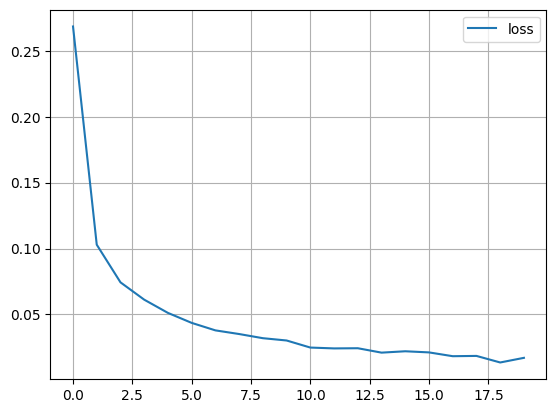

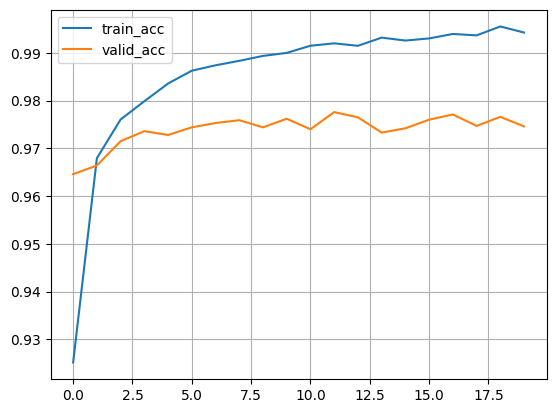

In [5]:
# 学習曲線の表示
import matplotlib.pyplot as plt

# 損失と精度の推移
plt.figure()
plt.plot(hist_avg_loss, label="loss")
plt.legend()
plt.grid()

plt.figure()
plt.plot(hist_train_acc, label="train_acc")
plt.plot(hist_valid_acc, label="valid_acc")
plt.legend()
plt.grid()

plt.show()

In [6]:
# モデルの保存
torch.save(model.state_dict(), "mnist_model_bitlinear.pth")